In [1]:
import numpy as np
import pandas as pd
import pickle
import datetime as dt
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import make_scorer, roc_auc_score, classification_report, confusion_matrix, f1_score, \
precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE


# suppressing pesky warnings

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
import catboost as cb

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

# Visualisation
#import geopandas as gpd
#from geopandas import GeoDataFrame
#from pyproj import CRS
#from shapely.geometry import Point, Polygon

### We will build and compare the following models, then choose one to use on the test set:

- Decision Tree
- Random Forest
- KNearest Neighbors
- Catboost
- XGBoost
- Voting Classifier that incorporates above models

The basic procedure for building each model is similar. First, we split the training data 80-20. Each model will test on the 20%, and the model that performs the best on that set will be used on the actual test set.

For each model ,we create set of model parameters to iterate through and find the best set of parameters to fit the 80% training data using grid search, determined by best ROC_AUC values. We then save those models to a pickle file, using these models as inputs to the voting classifier model

In [2]:
train_data = pd.read_csv("train_data.csv", index_col = 0)

X = train_data.iloc[:, 1:]
y = train_data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)


In [3]:
len(x_train), len(y_train), len(x_test), len(y_test), len(train_data)

(4328, 4328, 1082, 1082, 5410)

In [4]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.906423
1    0.093577
Name: Fraud, dtype: float64
0    0.906654
1    0.093346
Name: Fraud, dtype: float64


### Here, we handle data imbalacing using SMOTE

In [5]:
sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train, y_train)

In [6]:
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts(normalize = True))

(7846, 11)
(7846,)
0    0.5
1    0.5
Name: Fraud, dtype: float64


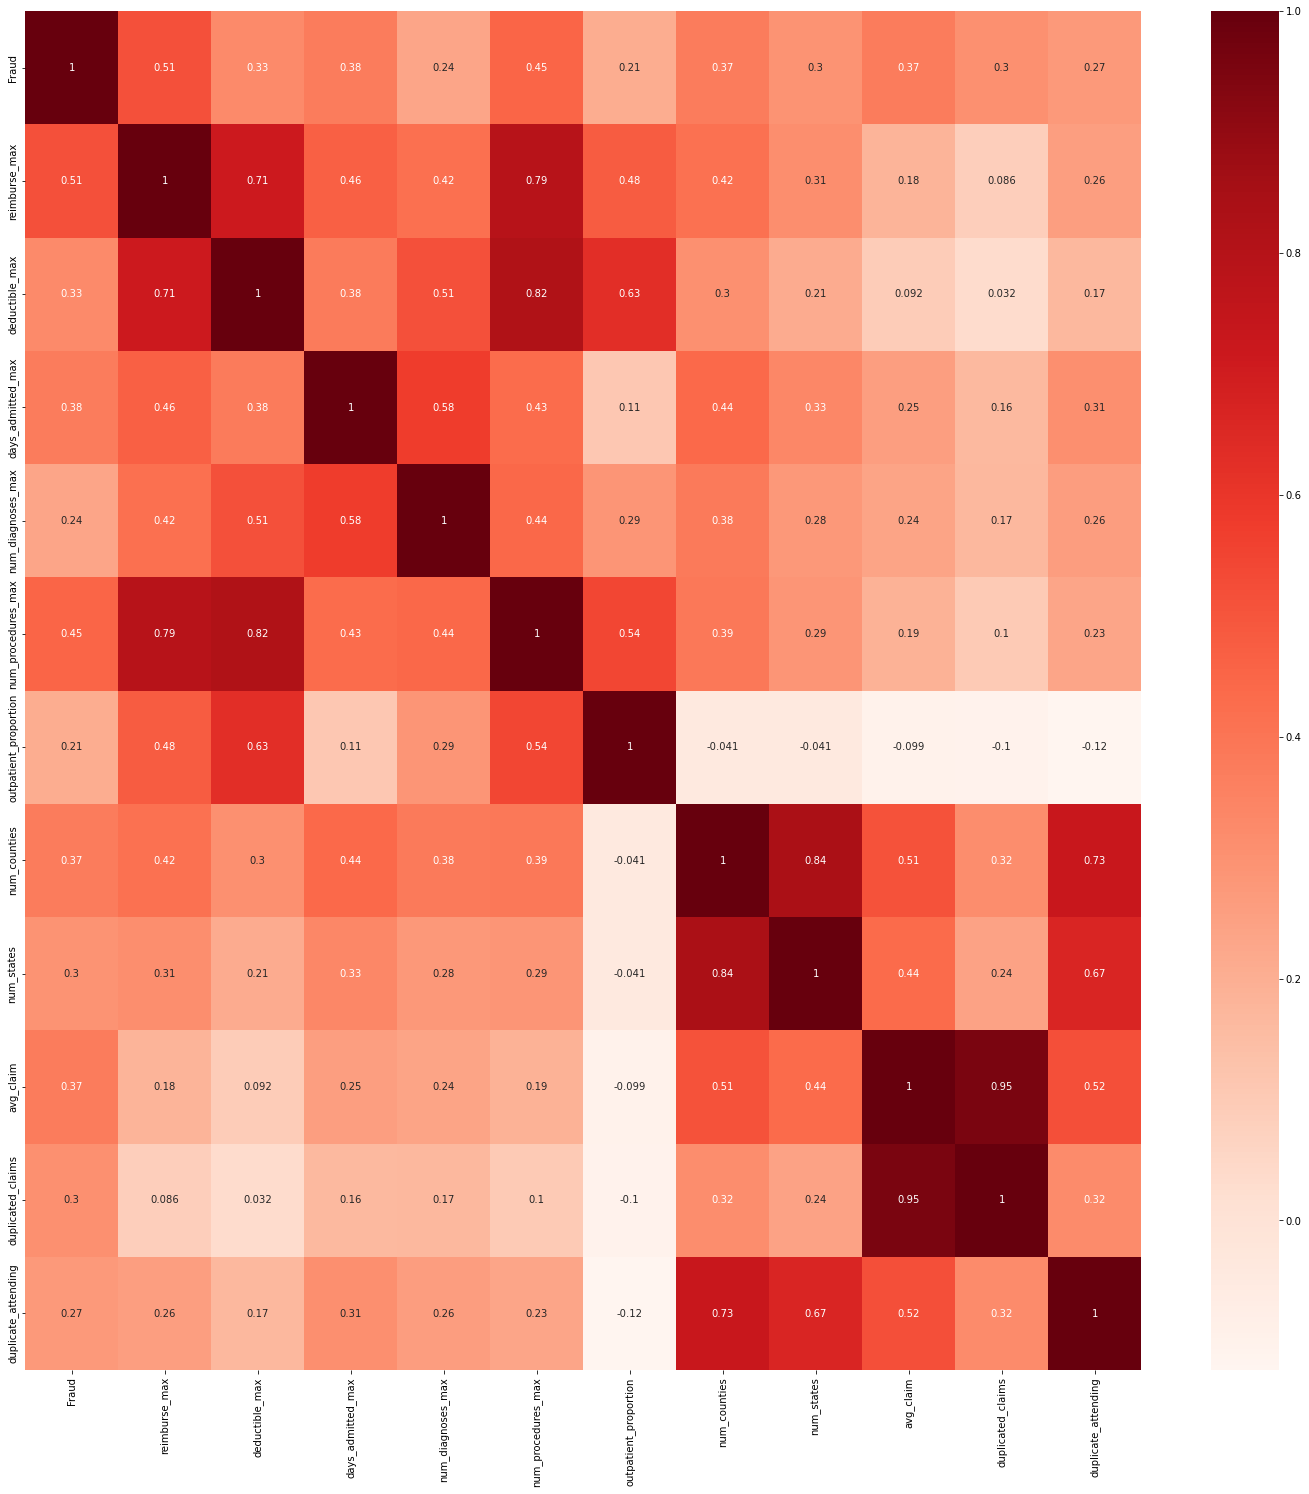

In [7]:
plt.figure(figsize=(25,25))
cor = train_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Model 1: Decision Tree

In [8]:
def createRandomGrid():
    
    criterion = ["gini", "entropy"]
    max_depth = range(1,5)
    min_samples_split = range(2,10)
    min_samples_leaf = range(1,10)
    #min_samples_split = [2, 5, 10, 20]
    #min_samples_leaf = [1, 20, 40, 100]
    
    random_grid = {"criterion": criterion ,
             "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              }
        
    #random_grid = {"criterion": criterion}
    
    return random_grid

def runDecisionTree(random_grid, x_train, y_train):
    
    #rmse_score = make_scorer(rmse, greater_is_better = False)
    
    decision_tree = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(decision_tree, random_grid, cv=10, scoring='roc_auc', n_jobs = -1)
    grid_search.fit(x_train, y_train)
    final = grid_search.best_params_
    print(final)
    print(grid_search.best_score_)
    return grid_search.best_estimator_

param_set = createRandomGrid()
best_model = runDecisionTree(param_set, x_train, y_train)
best_model.fit(x_train,y_train)
pickle.dump(best_model, open("DecisionTreeOverModel.pkl", 'wb'))

{'criterion': 'entropy', 'min_samples_leaf': 9, 'min_samples_split': 2}
0.9626819781211285


### Model 2: K-Nearest Neighbors

In [9]:
def createRandomGrid():
    
    n_neighbors = [2,5,10,15]
    weights = ['uniform', 'distance']
    metric = ['euclidean', 'manhattan']
    
    random_grid = {'n_neighbors': n_neighbors, 
                   'weights': weights,
                  'metric': metric}

    
    
    return random_grid

def runKNeighbors(random_grid, x_train, y_train):
    
#     rmse_score = make_scorer(rmse, greater_is_better = False)
    
    K_neigh = KNeighborsClassifier()
    grid_search = GridSearchCV(K_neigh, random_grid, cv=5, scoring='roc_auc', n_jobs = -1)
    grid_search.fit(x_train, y_train)
    final = grid_search.best_params_
    print(final)
    print(grid_search.best_score_)
    return grid_search.best_estimator_

param_set = createRandomGrid()
best_model = runKNeighbors(param_set, x_train, y_train)
best_model.fit(x_train,y_train)
pickle.dump(best_model, open("KNeighborsOver.pkl", 'wb'))

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
0.9757625627069361


### Model 3: Random Forest

In [10]:
def createRandomGrid():
    n_estimators = [10 , 50, 100, 200, 400, 500]
    max_features = [6,8,10,12, 14 ]
    max_depth = [2] 
    min_samples_leaf = [1,5,10,25,50]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                   'bootstrap': bootstrap,
                    'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_leaf': min_samples_leaf
                                    }
    
    return random_grid

def runRandomForest(random_grid, x_train, y_train):
    
    forest = RandomForestClassifier(random_state = 42)
    grid_search = GridSearchCV(forest, random_grid, cv=5, scoring='roc_auc', n_jobs = -1)
    grid_search.fit(x_train, y_train)
    final = grid_search.best_params_
    print(final)
    print(grid_search.best_score_)
    return grid_search.best_estimator_

param_set = createRandomGrid()
best_model = runRandomForest(param_set, x_train, y_train)
best_model.fit(x_train,y_train)
pickle.dump(best_model, open("RandomForestOverModel.pkl", 'wb'))

{'bootstrap': True, 'max_depth': 2, 'max_features': 6, 'min_samples_leaf': 50, 'n_estimators': 200}
0.9534060615117887


In [11]:
# rfc = RandomForestClassifier()
# rfc.fit(x_train, y_train)
# y_pred_prob = rfc.predict_proba(x_test)[:, 1]

In [12]:
# for i in np.round(np.linspace(0.05, 0.95, 19), 3):
#     print('#########################')
#     print('Threshold =', i)
#     yp = np.where(y_pred_prob >= i, 1, 0)
#     print(classification_report(y_test, yp), confusion_matrix(y_test, yp), roc_auc_score(y_test, yp))
#     print('#########################')

# Model 4: XGBoost

In [13]:
def createRandomGrid():
        
        random_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

    
        return random_grid

def runXGB(random_grid, x_train, y_train):
    
    xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
    
    
    
    grid_search = GridSearchCV(xgb, random_grid, cv=5, scoring='roc_auc', n_jobs = 4, verbose=3)
    grid_search.fit(x_train, y_train)
    final = grid_search.best_params_
    print(final)
    print(grid_search.best_score_)
    return grid_search.best_estimator_


param_set = createRandomGrid()
best_model = runXGB(param_set, x_train, y_train)
best_model.fit(x_train,y_train)
pickle.dump(best_model, open("XGBOverModel.pkl", 'wb'))

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[11:16:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:16:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6}
0.989177910516716
[11:16:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could

### Model 5: Cat Boost

In [14]:
def createRandomGrid():
        
        random_grid = {
        'learning_rate': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'depth': [1,2,3,4,5,6,7],
        'l2_leaf_reg': [1,2,3,4,5,6,7,8,9,10]
        }

    
        return random_grid

def runCat(random_grid, x_train, y_train):
    
    cat = cb.CatBoostClassifier(silent=True)
    
    
    
    grid_search = GridSearchCV(cat, random_grid, cv=5, scoring='roc_auc', n_jobs = 4, verbose=3)
    grid_search.fit(x_train, y_train)
    final = grid_search.best_params_
    print(final)
    print(grid_search.best_score_)
    return grid_search.best_estimator_


param_set = createRandomGrid()
best_model = runCat(param_set, x_train, y_train)
best_model.fit(x_train,y_train)
pickle.dump(best_model, open("CatOverModel.pkl", 'wb'))

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
{'depth': 7, 'l2_leaf_reg': 3, 'learning_rate': 0.4}
0.9929074702703508


### Model 6: Voting Regressor

In [15]:
loaded_rf_model = pickle.load(open("RandomForestOverModel.pkl", 'rb'))
loaded_kn_model = pickle.load(open("KNeighborsOver.pkl", 'rb'))
loaded_dt_model = pickle.load(open("DecisionTreeOverModel.pkl", 'rb'))
loaded_xg_model = pickle.load(open("XGBOverModel.pkl", 'rb'))
loaded_cb_model = pickle.load(open('CatOverModel.pkl', 'rb'))


vtr = VotingClassifier([('rf', loaded_rf_model), ('kn', loaded_kn_model), ('dt', loaded_dt_model), ('xg', loaded_xg_model),
                        ('cb', loaded_cb_model)])
vtr.fit(x_train,y_train)
pickle.dump(vtr, open("VotingClassifierOverModel.pkl", 'wb'))

[12:39:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:39:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Model Evaluation

Here we will load the optimal models we created and run them on our test set. For each model we calculate the following metrics:

- ROC_AUC Score
- Brier Score
- Precision and Recall

In [1]:
#loading files

rf_model = pickle.load(open("RandomForestOverModel.pkl", 'rb'))
kn_model = pickle.load(open("KNeighborsOver.pkl", 'rb'))
dt_model = pickle.load(open("DecisionTreeOverModel.pkl", 'rb'))
vtr_model = pickle.load(open("VotingClassifierOverModel.pkl", 'rb'))
xg_model = pickle.load(open("XGBOverModel.pkl", 'rb'))
cb_model = pickle.load(open('CatOverModel.pkl', 'rb'))

#x_train = pickle.load(open("SplitTrainX_V2.pkl", 'rb'))
#x_test = pickle.load(open("SplitTestX_V2.pkl", 'rb'))
#y_train = pickle.load(open("SplitTrainY_V2.pkl", 'rb'))
#y_test = pickle.load(open("SplitTestY_V2.pkl", 'rb'))

NameError: name 'pickle' is not defined

In [18]:
def brier_score(y_test, y_pred):
    return (1 / len(y_pred)) * sum((y_pred - y_test)**2)

In [19]:
#Looping through each model and running it on test set

model_list = [rf_model, kn_model, dt_model, vtr_model,xg_model, cb_model]
model_names = ["RandomForest", "KNearestNeighbors", "DecisionTree", "VotingClassifier", "XGBoost", 'CatBoost']
roc_auc_list = []
results_df_list = []
for i in range(6):
    model = model_list[i]
    model_name = model_names[i]
    y_test_predictions =  model.predict(x_test)
    y_train_predictions = model.predict(x_train)

#     rmse_test = math.sqrt(mean_squared_error(y_test, y_test_predictions))
#     rmse_train = math.sqrt(mean_squared_error(y_train, y_train_predictions))
    roc_auc_test = roc_auc_score(y_test, y_test_predictions)
    roc_auc_train = roc_auc_score(y_train, y_train_predictions)
    cv_scores = cross_val_score(model, x_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    roc_auc_cv = cv_scores.mean()
    f1 = f1_score(y_test, y_test_predictions)
    if(model_name == 'VotingClassifier'):
        brier = np.nan
    else:
        y_test_pred_prob = model.predict_proba(x_test)[:, 1]
        brier = brier_score(y_test, y_test_pred_prob)
    precision_test = precision_score(y_test, y_test_predictions)
    recall_test = recall_score(y_test, y_test_predictions)
    cf = confusion_matrix(y_test, y_test_predictions)
    cf = cf.flatten()

    roc_auc_list.append([model_name,roc_auc_train,roc_auc_cv, roc_auc_test, f1, brier, precision_test, recall_test, 
                         cf[0], cf[1], cf[2], cf[3]])
    
    y_test = np.array(list(y_test))
    y_test_predictions = np.array(y_test_predictions)
    dfi = pd.DataFrame({'Actual IR': y_test, 'Predicted IR': y_test_predictions})
    results_df_list.append(dfi)

In [20]:
roc_auc_df = pd.DataFrame(roc_auc_list, columns = ["Model Name", "Train ROC AUC", "CV ROC AUC", "Test ROC AUC", 
                                                   'Test F1 Score', 'Brier Score', 'Test Precision', 'Test Recall', 
                                                   'Test TN', 'Test FN', 'Test FP', 'Test TP'])
roc_auc_df.sort_values(by=['Test ROC AUC'], ascending = False)

,Model Name,Train ROC AUC,CV ROC AUC,Test ROC AUC,Test F1 Score,Brier Score,Test Precision,Test Recall,Test TN,Test FN,Test FP,Test TP
0,RandomForest,0.902243,0.953427,0.862108,0.609665,0.078296,0.488095,0.811881,895,86,19,82
3,VotingClassifier,0.987382,NaN,0.818865,0.601695,NaN,0.525926,0.702970,917,64,30,71
4,XGBoost,0.973745,0.989982,0.813042,0.610619,0.058694,0.552000,0.683168,925,56,32,69
2,DecisionTree,0.955136,0.962682,0.790035,0.552301,0.079181,0.478261,0.653465,909,72,35,66
5,CatBoost,1.000000,0.993320,0.787416,0.594340,0.063216,0.567568,0.623762,933,48,38,63
1,KNearestNeighbors,1.000000,0.977098,0.785156,0.503704,0.090894,0.402367,0.673267,880,101,33,68


In [23]:
y_pred_prob = rf_model.predict_proba(x_test)[:, 1]

In [24]:
for i in np.round(np.linspace(0.05, 0.95, 19), 3):
    print('#########################')
    print('Threshold =', i)
    yp = np.where(y_pred_prob >= i, 1, 0)
    print(classification_report(y_test, yp), confusion_matrix(y_test, yp), roc_auc_score(y_test, yp), recall_score(y_test, yp))
    print('#########################')

#########################
Threshold = 0.05
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       981
           1       0.09      1.00      0.17       101

    accuracy                           0.09      1082
   macro avg       0.05      0.50      0.09      1082
weighted avg       0.01      0.09      0.02      1082
 [[  0 981]
 [  0 101]] 0.5 1.0
#########################
#########################
Threshold = 0.1
              precision    recall  f1-score   support

           0       1.00      0.50      0.66       981
           1       0.17      0.98      0.29       101

    accuracy                           0.54      1082
   macro avg       0.58      0.74      0.47      1082
weighted avg       0.92      0.54      0.63      1082
 [[487 494]
 [  2  99]] 0.7383151159152612 0.9801980198019802
#########################
#########################
Threshold = 0.15
              precision    recall  f1-score   support

           0       